In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/SphericalAndRamp/Annular_Spherical/'
lam = 0.8
tau = 35.

In [2]:
pulseParams = {
    'Nt' : 2**6,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
}
pulseNx = 2**11
pulseNy = 2**11
pulseX = 3e4
pulseY = 3e4

beamNx = 2**12
beamNy = 2**12
beamX = 6e4
beamY = 6e4

plasmaParams = {
    'Nx' : pulseNx,
    'Ny' : pulseNy,
    'Nz' : 2**8,
    'X' : pulseX,
    'Y' : pulseY,
    'Z' : 2.0e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

In [3]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 5.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.50, zf)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(z/1e6, I)
plt.title('Intensity profile')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'I ($10^{14}W/cm^2$)')
plt.xlim([0, 7]);

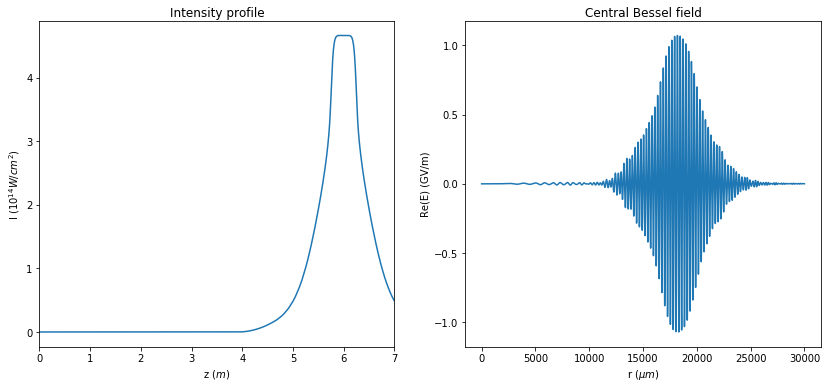

In [4]:
# Create the input field for the central mode with the ramps
params = {
    'Nr' : 5000,
    'R' : 30e3,
    'w' : 100,
    'lam' : lam
}
rJ0, EJ0 = bessel.bessel_expansion(params, z, I)
plt.subplot(122)
plt.plot(rJ0, EJ0.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

In [5]:
def plot_longitudinal(beam):
    print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                         beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
    beam.propagate(z0 + dz/2 - 1e6, 1.0) # propagate to the start of the plasma
    #beam.plot_current_intensity(lim=[-2000, 2000])
    N = 100
    z = np.linspace(0, 2.0e6, N)
    beam.propagate(z, 1.0)
    e = np.zeros((N, beamNx), dtype='complex128')
    for i in range(N):
        e[i, :] = beam.load_field(i+1)[0]

    lonn = adk.gaussian_frac(ionization.Ar['EI'], abs(e), tau, ionization.Ar['Z'], ionization.Ar['l'])
    lonn = beam.prep_data(lonn)
    lonI = beam.intensity_from_field(e)
    lonI = beam.prep_data(lonI)

    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(lonI, aspect='auto', extent=[0, 2e6, -beamX/2, beamX/2])
    cb = plt.colorbar()
    cb.set_label(r'Intensity')
    plt.set_cmap('viridis')
    plt.xlabel(r'z')
    plt.ylabel(r'x')
    plt.ylim([-1000, 1000])
    plt.title('Longitudinal intensity')
    
    plt.subplot(122)
    plt.imshow(lonn, aspect='auto', extent=[0, 2e6, -beamX/2, beamX/2])
    cb = plt.colorbar()
    cb.set_label(r'Ionization fraction')
    plt.set_cmap('plasma')
    plt.xlabel(r'z')
    plt.ylabel(r'x')
    plt.ylim([-1000, 1000])
    plt.title('Longitudinal plasma density')
    plt.tight_layout()
    plt.show()

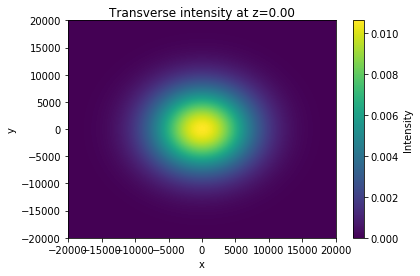

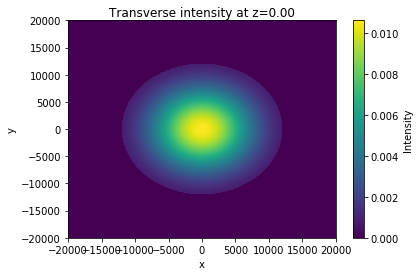

In [6]:
# Calculate the plasma density for the central mode
from ionization import adk
pulseParams['name'] = 'SBeam'
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['E0'] = 200
pulseParams['waist'] = 150
pulseParams['z0'] = -1*(z0 + dz)
beam = laserbeam.GaussianLaser(pulseParams)
beam.plot_current_intensity(lim=[-2e4, 2e4])

# Remove an annulus from the center of the cell
x = beam.x
y = beam.y
r = np.sqrt(x[:, None]**2 + y[None, :]**2)
sel = r > 12e3
beam.e[sel] = 0.0
beam.plot_current_intensity(lim=[-2e4, 2e4])

Power: 1.73118905752


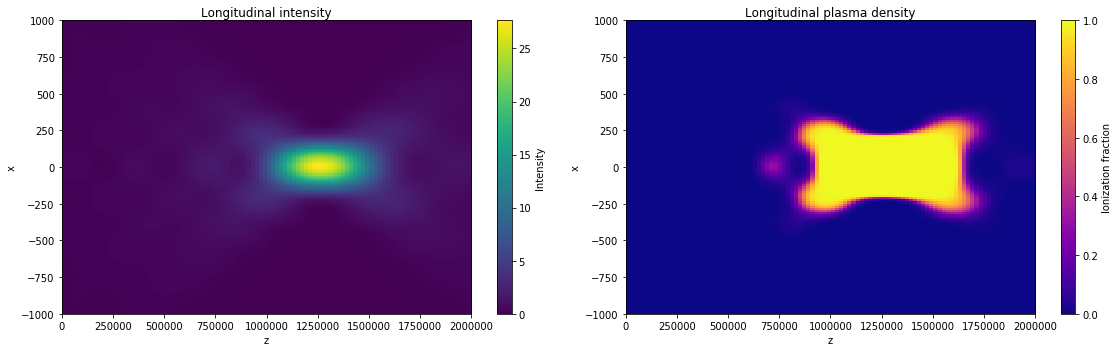

In [7]:
plot_longitudinal(beam)

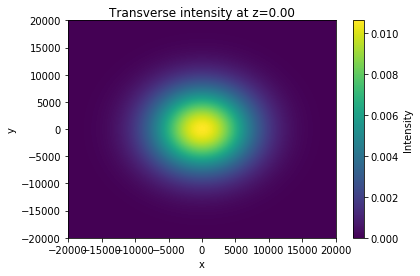

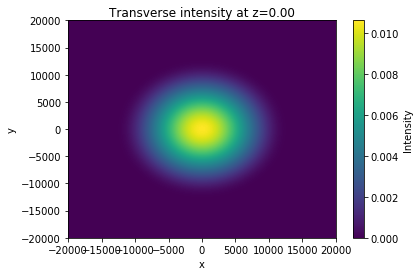

In [8]:
# Calculate the plasma density for the central mode
from ionization import adk
pulseParams['name'] = 'SBeam'
pulseParams['E0'] = 200
pulseParams['waist'] = 150
pulseParams['z0'] = -1*(z0 + dz)
beam = laserbeam.GaussianLaser(pulseParams)
beam.plot_current_intensity(lim=[-2e4, 2e4])

# Remove an annulus from the center of the cell
x = beam.x
y = beam.y
r = np.sqrt(x[:, None]**2 + y[None, :]**2)
mask = np.exp(-(r/12e3)**8)
beam.e *= mask
beam.plot_current_intensity(lim=[-2e4, 2e4])

Power: 1.56570551928


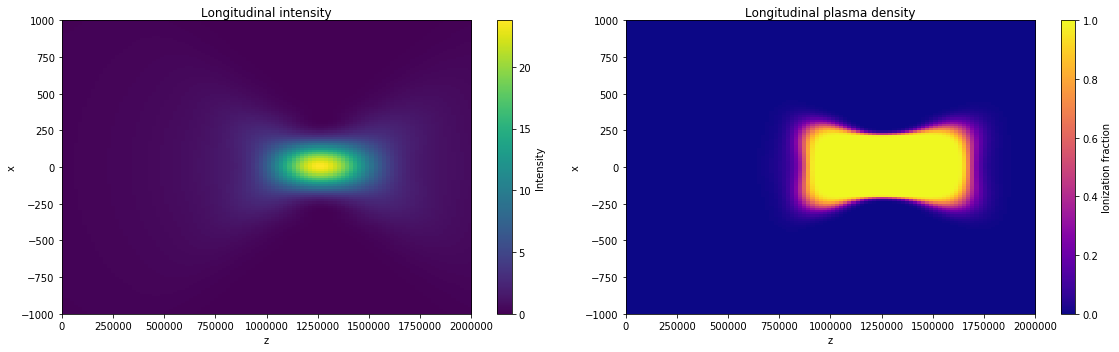

In [9]:
plot_longitudinal(beam)

Power: 0.880709354592


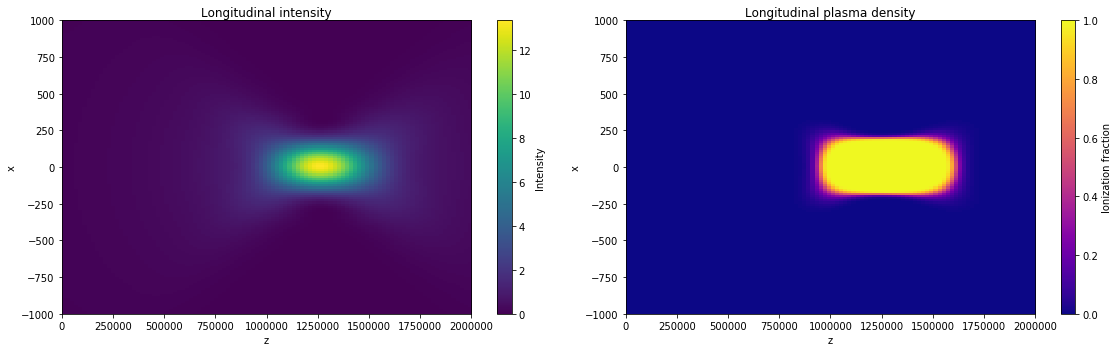

Power: 1.78191964722


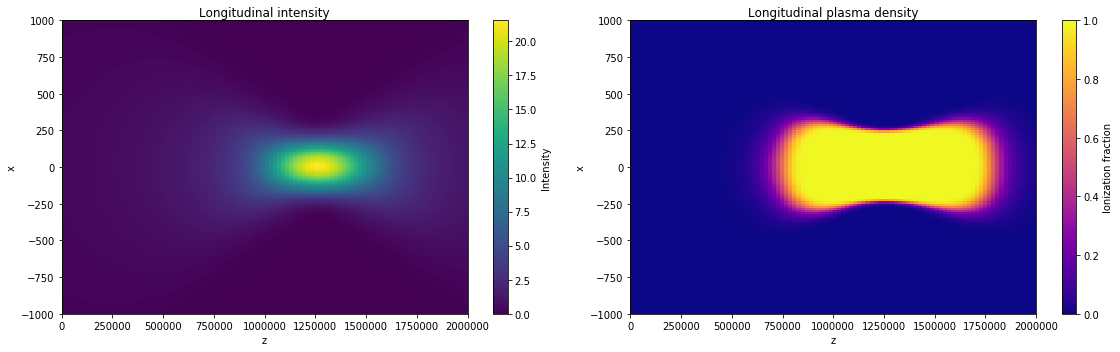

Power: 2.89090295205


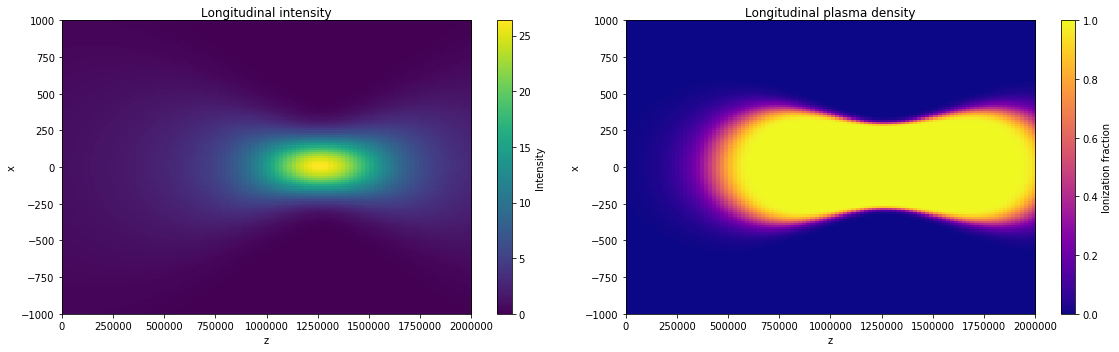

Power: 1.56570551928


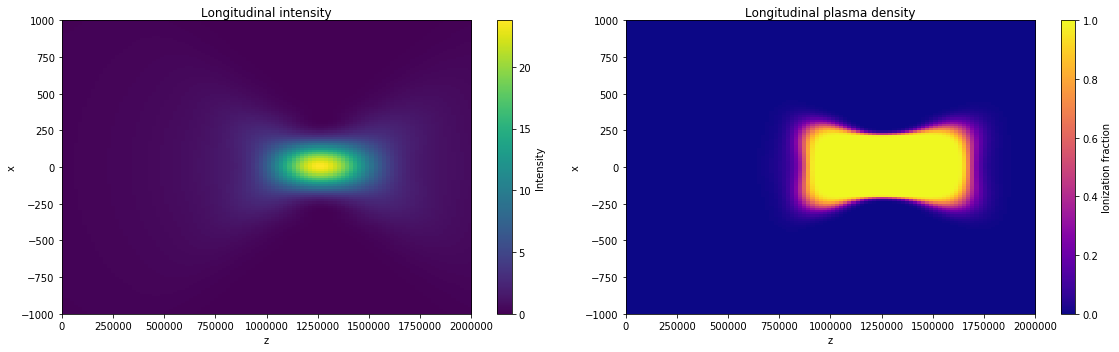

Power: 3.16785715062


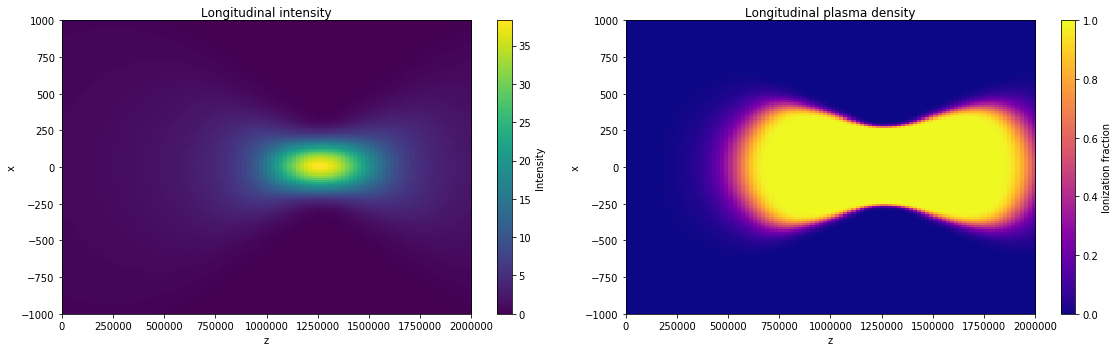

Power: 5.13938302587


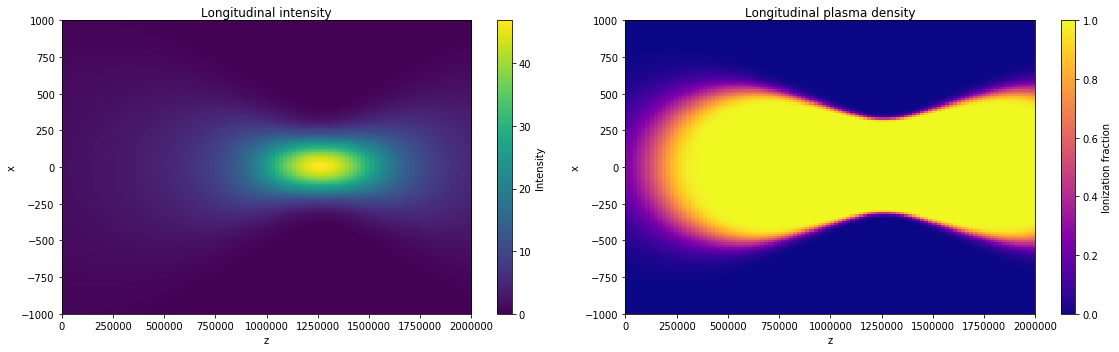

Power: 2.44641487387


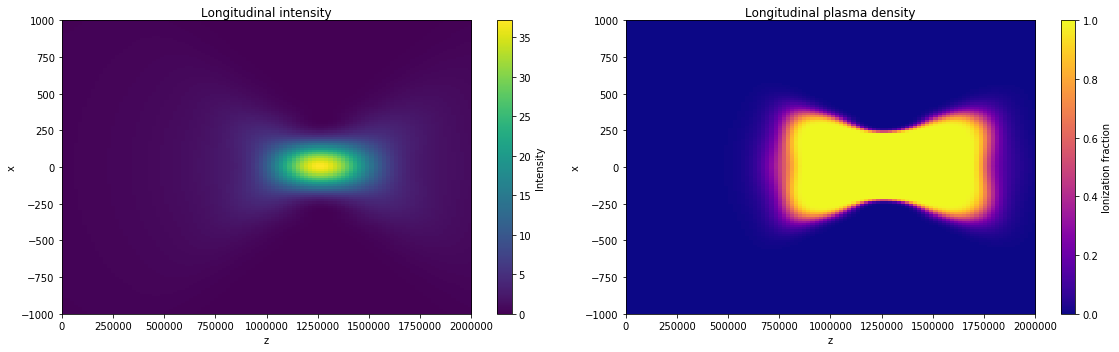

Power: 4.94977679784


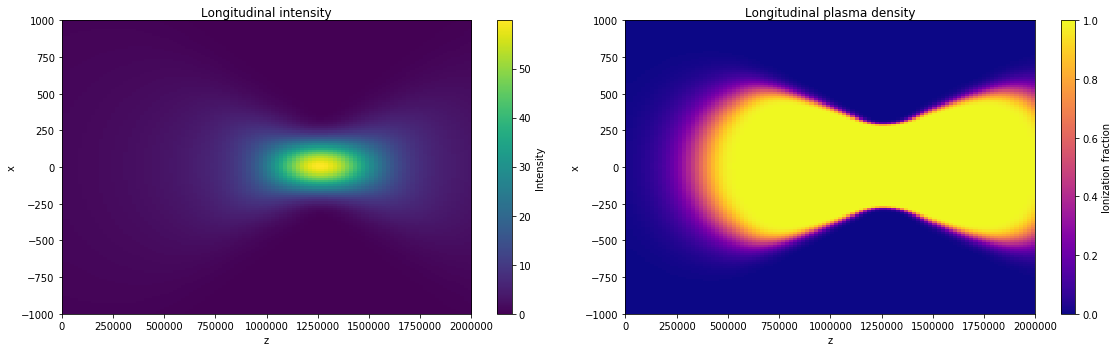

Power: 8.03028597792


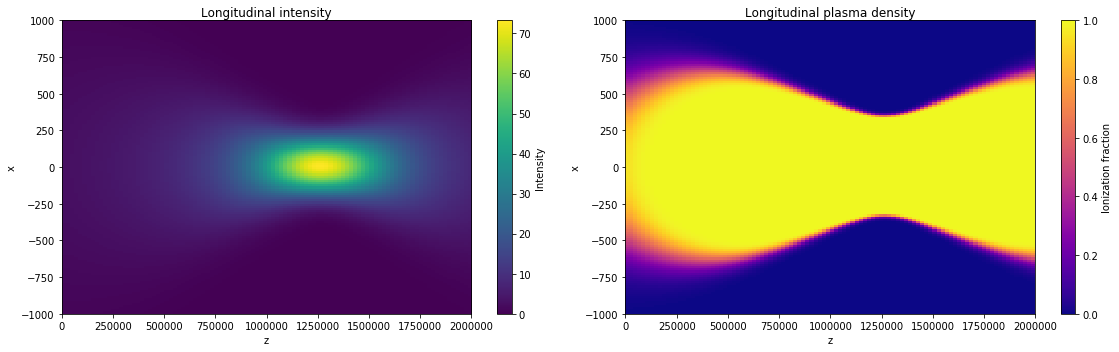

Power: 3.52283741837


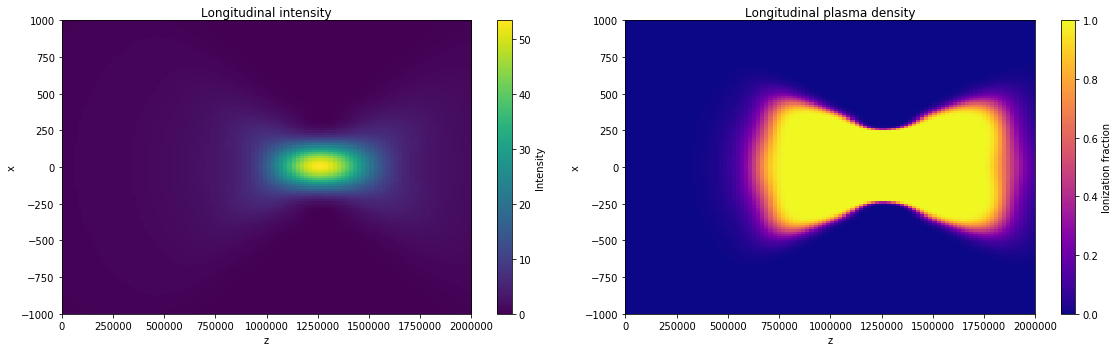

Power: 7.12767858889


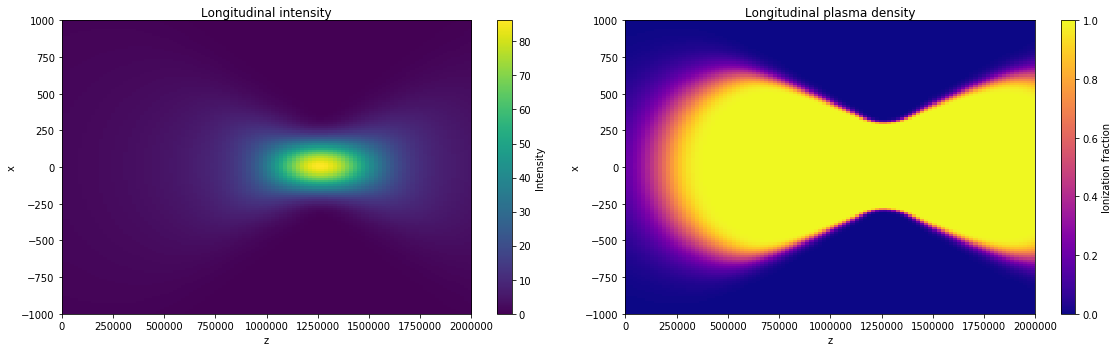

Power: 11.5636118082


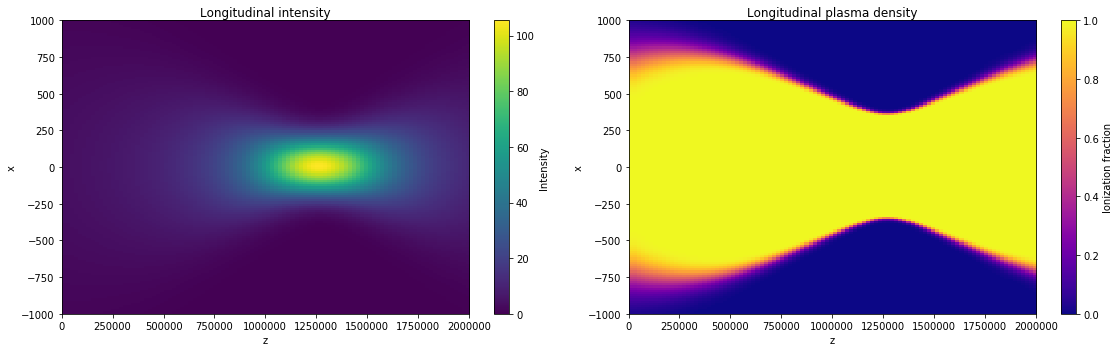

In [10]:
# Calculate the plasma density for the unrefracted spherical lenses
pulseParams['z0'] = -1*(z0 + dz)
E0 = [150., 200., 250., 300.]
waist = [150., 200., 250.]
for i in range(len(E0)):
    for j in range(len(waist)):
        pulseParams['name'] = 'E0-%3.0f_waist-%3.0f_SBeam' % (E0[i], waist[j])
        pulseParams['E0'] = E0[i]
        pulseParams['waist'] = waist[j]
        beam = laserbeam.GaussianLaser(pulseParams)
        x = beam.x
        y = beam.y
        r = np.sqrt(x[:, None]**2 + y[None, :]**2)
        mask = np.exp(-(r/12e3)**8)
        beam.e *= mask
        plot_longitudinal(beam)

In [ ]:
# Calculate the plasma density for the central mode
multiJ0 = 1.0
pulseParams['name'] = 'J0Beam'
pulseParams['order'] = 0
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rJ0
pulseParams['E'] = multiJ0 * EJ0
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'J0Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
plasmaParams['name'] = 'Plasma0'
argon = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

In [ ]:
# Calculate the plasma density for the spherical modes
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['z0'] = -1.25e6
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'Plasma0'
for i in range(len(E0)):
    for j in range(len(waist)):
        pulseParams['name'] = 'SBeam
        pulseParams['E0'] = E0[i]
        pulseParams['waist'] = waist[j]
        beam = laserbeam.GaussianLaser(pulseParams)
        x = beam.x
        y = beam.y
        r = np.sqrt(x[:, None]**2 + y[None, :]**2)
        mask = np.exp(-(r/12e3)**8)
        beam.e *= mask
        beam.propagate(z0 + dz/2 - 1e6, 1.0)
        pulseParams['name'] = 'E0-%3.0f_waist-%3.0f_SPulse' % (E0[i], waist[j])
        pulseParams['E0'] = E0[i]
        pulseParams['waist'] = waist[j]
        pulse = laserpulse.GaussianPulse(pulseParams)
        plasmaParams['name'] = 'E0-%3.0f_waist-%3.0f_SPlasma' % (E0[i], waist[j])
        argon = plasma.ExistingPlasma(plasmaParams)
        interactions.pulse_plasma(pulse, argon)
        argon.plot_long_density_center(lim=[-1000, 1000])